Para comenzar, vamos a hacer los imports y a declarar funciones que nos ayuden a dibujar las imágenes de forma más sencilla durante el resto de la práctica.

In [4]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

def BRG2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def readIMG(filename,flagColor = 1):
    return BRG2RGB(cv2.imread(filename,flagColor))

#Found on: https://note.nkmk.me/en/python-opencv-hconcat-vconcat-np-tile/. Concats readjusting size
def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)

def pintaI(im,title = "img"):
    plt.title(title)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

def pintaMI(vim,title = "imgs"):

    #Pasa a "formato color" las imágenes que estén en blanco y negro
    for i,im in enumerate(vim):
        if len(im.shape) == 2:
            vim[i] = cv2.cvtColor(vim[i],cv2.COLOR_GRAY2BGR)

    #Use found function to resize
    images = hconcat_resize_min(vim)
    pintaI(images,title)

def pintaMIReduced(vim,title = "imgs"):
    
    hmax = max(im.shape[0] for im in vim)
    for i,im in enumerate(vim):
        if len(im.shape) == 2:
            vim[i] = cv2.cvtColor(vim[i],cv2.COLOR_GRAY2BGR)
        if im.shape[0] < hmax:
            vim[i] = cv2.copyMakeBorder(vim[i], 0,hmax - im.shape[0],0,0,borderType=cv2.BORDER_CONSTANT)
    
    images = cv2.hconcat(vim)
    pintaI(images)

def pintaMITitles(vim,titles):
    title = " - ".join(titles)
    pintaMI(vim,title)
    

Vamosa  leer un par de imágenes y a dibujar su estado original antes de comenzar 

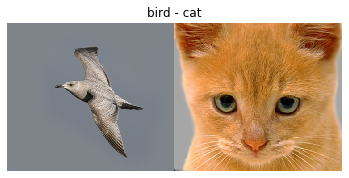

In [5]:
bird = readIMG('imagenes/bird.jpg')
cat  = readIMG('imagenes/cat.jpg')
pintaMITitles([bird,cat],["bird","cat"])

Vamos ahora a tratar de implementar las funciones que se nos piden. Vamos a aplicar una Gaussiana 2D a una imagen. Necesitaremos como parámetros los sigmas que se aplicarán a cada eje, así como el tamaño del kernel. Como parámetro por defecto, se establece sigma2 a cero, pues *GaussianBlur* se encarga de copiar el valor de sigma1 en sigma2 si este vale 0.

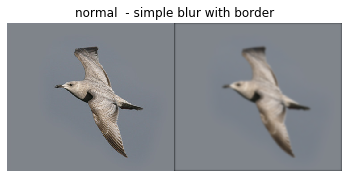

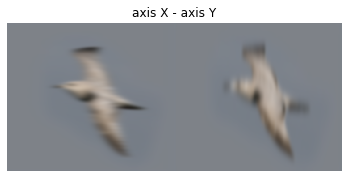

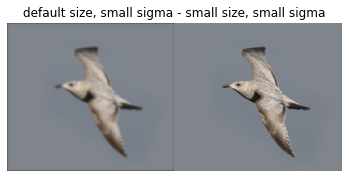

In [6]:
def gaussian2D(img,size,sigma1,sigma2,border = cv2.BORDER_DEFAULT):
    return cv2.GaussianBlur(img,ksize = size,sigmaX=sigma1,sigmaY=sigma2,borderType = border) 
    """ 
    Apply gaussian2D filter to an image. Parameters sigma1 and sigma2 are the coeficients in axis X and Y respectively.
    Border can be changed using different cv2 borders such as BORDER_REPLICATE, BORDER_WRAP
    """
b1 = gaussian2D(bird,(0,0),2,2, cv2.BORDER_ISOLATED)
b2 = gaussian2D(bird,(0,0),10,2)
b3 = gaussian2D(bird,(0,0),2,10)
b4 = gaussian2D(bird,(3,3),2,2)
b5 = gaussian2D(bird,(9,9),11,11)
pintaMITitles([bird,b1],["normal ","simple blur with border"])
pintaMITitles([b2,b3],["axis X", "axis Y"])
pintaMITitles([b1,b4],["default size, small sigma","small size, small sigma"])

Podemos ver que si ponemos un sigma alto en uno de los ejes y bajo en el otro, el suavizado se hace de forma **más intensa** en el eje que tenga el sigma más alto, por lo que la imagen queda "alargada" en ese eje.

También podemos apreciar que si damos al kernel un tamaño que no sea $(0,0)$, al aplicar el filtro gaussiano con valores de sigma bajos, el resultado es diferente que si el tamaño es $(0,0)$, esto es debido a que si el tamaño es $(0,0)$, estamos indicando que en realidad este se calculará en función de los sigmas. La imagen final cuando el tamaño del kernel no se calcula automáticamente según los sigmas queda menos difuminada que si el tamaño es $(0,0)$

Ahora, vamos a aplicar máscaras 1D dadas por *getDerivKernels*


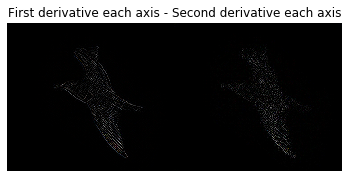

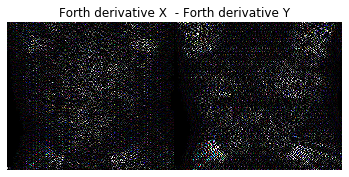

In [7]:
def maskDerivKernels(img,dx = 1,dy = 1,ksize = 3,border = cv2.BORDER_REPLICATE):
    """
    getDerivKernels returns coefficients to get images partial derivatives.
    dx and dy are respectively the partial orders for x and y.
    """
    dxdy = cv2.getDerivKernels(dx,dy,ksize)
    return cv2.sepFilter2D(img,-1,dxdy[0],dxdy[1],border)

imgDeriv1 = maskDerivKernels(bird)
imgDeriv2 = maskDerivKernels(bird,2,2)
imgDeriv3 = maskDerivKernels(cat,4,1,5)
imgDeriv4 = maskDerivKernels(cat,1,4,5)

pintaMITitles([imgDeriv1,imgDeriv2],["First derivative each axis","Second derivative each axis"])
pintaMITitles([imgDeriv3,imgDeriv4],["Forth derivative X ", "Forth derivative Y"])

Al aplicar derivadas sobre una imagen, lo que estamos tratando de hallar es los cambios de tonalidades que se dan en la imagen. Podemos ver que a medida que aumentamos las derivadas en uno de los ejes, nuestro método trata de encontrar los cambios de tonalidad que hay en nuestra imagen de forma más fuerte. Así, como podemos ver en las dos últimas imágnes, si aumentamos la derivada en el eje X, nos aparecen más lineas verticales" en la imagen, y si aumentamos la derivada en el eje Y nos aparecen *lineas más horizontales*

Continuamos

Vamos a implementar una función que utilice la función *Laplacian* para calcular la convolución 2D de una máscara normalizada de Laplaciana de Gaussiana de tamaño variable. Para ello, estableceremos la profundidad deseada al valor *CV_16S* que es indicador de 1 canal de enteros con signo de dos bytes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


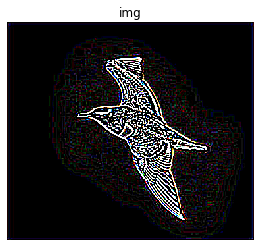

In [10]:
def laplacian(img,size):
    return cv2.Laplacian(img, ddepth = cv2.CV_16S, ksize=size)

test = laplacian(bird,5)
pintaI(test)

In [ ]:
Vemos que lo que conseguimos es un efecto que es parecido al que conseguimos al aplicar las máscaras $1D$ con *getDerivKernels*.

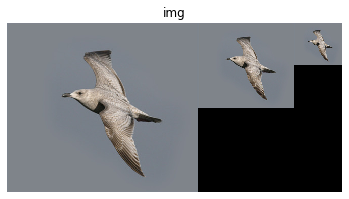

In [12]:
def subsampling(img):
    return img[::2, ::2]

sub = subsampling(bird)
subsub = subsampling(sub)

pintaMIReduced([bird,sub,subsub])

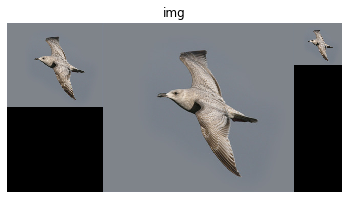

In [16]:
def upsample(img):
    i = [2*a for a in range(0,img.shape[0])]
    j = [2*a for a in range(0,img.shape[1])]
    for a in i:
        img = np.insert(img,a+1,img[a,:],axis = 0)
        
    for a in j:
        img = np.insert(img,a+1,img[:,a],axis = 1)
        
    return img
        
up = upsample(bird)
upup = upsample(up)
pintaMIReduced([up,upup,bird])
        
    